In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing necessary modules**

In [3]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3293184/45929032 bytes (7.2%)6987776/45929032 bytes (15.2%)10543104/45929032 bytes (23.0%)14450688/45929032 bytes (31.5%)18178048/45929032 bytes (39.6%)22077440/45929032 bytes (48.1%)25608192/45929032 bytes (55.8%)29474816/45929032 bytes (64.2%)33275904/45929032 bytes (72.5%)37076992/45929032 bytes (80.7%)40943616/45929032 bytes (89.1%)44859392/45929032 bytes (97.7%)

In [4]:
pip install np_utils

     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-cp37-none-any.whl size=57133 sha256=b678a3db9686b1187be5e3ad755f4142f95644aadd8b06aaac0296fb2c9c70cb
  Stored in directory: /root/.cache/pip/wheels/92/4b/81/206efd0d01330a96f3aebe5021d2d5f0b264b7ade827c306ef
Successfully built np-utils


In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [7]:
from keras.models import Sequential, Model

## **Setting up numpy and Tensorflow seeds to get consistent results.**

In [8]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# **Data Preparation**



*   *image_height and image_weight: Dimension of each frame of videos*
*   *max_seq_length: Number of images passed as one sequence i.e. 2000 frames per video*



In [9]:
data_dir = "/content/drive/MyDrive/ML_Project/UCF50"
image_height , image_width = 64, 64
max_seq_length = 2000

The Dataset we are using is the **UCF50**

UCF50 is an action recognition dataset which contains:

  * 50 Action Categories consisting of realistic YouTube  videos
  * 25 Groups of Videos per Action Category
  * 133 Average Videos per Action Category
  * 199 Average Number of Frames per Video
  * 320 Average Frames Width per Video
  * 240 Average Frames Height per Video
  * 26 Average Frames Per Seconds per Video

*But since it has 50 different categories which will take a very long time to train therefore we’ll be using only 6 classes.*

In [10]:
class_categories_list = ["WalkingWithDog", "Basketball", "Swing", "HorseRace", "PushUps", "Rowing", "Diving", "Drumming", "GolfSwing", "JavelinThrow", "Kayaking", "PullUps"]

In [11]:
model_output_length = len(class_categories_list)

# **Extraction of frames from videos.**

In [12]:
max_pixel_value = 255
def extract_frame(video_path):
  frames_list = []

  #print(" the video file path is : {}".format(video_path))
  videoObj = cv2.VideoCapture(video_path)
  #print("the video object is: {}".format(videoObj))

  """ Iterating through Video Frames """
  while True:

    # Reading a frame from the video file
    success, image = videoObj.read()
    #print("the value of success is: {}".format(success))

    if not success:
      break

    resized_frame = cv2.resize(image, (image_height, image_width))

    """Normalize the resized frame by dividing it with 255 so that 
    each pixel value then lies between 0 and 1"""

    normalized_frame = resized_frame / max_pixel_value
    frames_list.append(normalized_frame)

    
  videoObj.release()

  return frames_list



# **Dataset Creation**

In [13]:
def data_creation():

  features, labels = list(), list()
  temp_list = []

  for class_index, class_name in enumerate(class_categories_list):

    print("extraction of video frames from class -> {} with class index -> {}".format(class_name, class_index))

    # creating the list of videos for the current class
    files_list = os.listdir(os.path.join(data_dir, class_name))

    #print("files_list : {}".format(files_list))

    """iteratively passing video files and extracting the frames from that file"""
    for file in files_list:

      video_file_path = os.path.join(data_dir, class_name, file)

      #print("for file : {} the video files path are : {}".format(file,video_file_path))

      # Calling the frame_extraction method for every video_file_path
      extracted_frames = extract_frame(os.path.join(os.path.join(data_dir, class_name), file))


      
      temp_list.extend(extracted_frames)

  
    features.extend(random.sample(temp_list, max_seq_length))
    labels.extend([class_index] * max_seq_length)
    temp_list.clear()


  features =  np.asarray(features)
  labels = np.asarray(labels)

  return features, labels

## calling **data_creation()** function to get features and labels of the data

In [14]:
features, labels = data_creation()

extraction of video frames from class -> WalkingWithDog with class index -> 0
extraction of video frames from class -> Basketball with class index -> 1
extraction of video frames from class -> Swing with class index -> 2
extraction of video frames from class -> HorseRace with class index -> 3
extraction of video frames from class -> PushUps with class index -> 4
extraction of video frames from class -> Rowing with class index -> 5
extraction of video frames from class -> Diving with class index -> 6
extraction of video frames from class -> Drumming with class index -> 7
extraction of video frames from class -> GolfSwing with class index -> 8
extraction of video frames from class -> JavelinThrow with class index -> 9
extraction of video frames from class -> Kayaking with class index -> 10
extraction of video frames from class -> PullUps with class index -> 11


In [15]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (24000, 64, 64, 3)
the shape of the labels = (24000,)


In [16]:
# features_5D = features[np.newaxis, ...]

In [17]:
# features_5D.shape

## convert class labels to one hot encoded vectors

In [18]:
# converting labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# **Splitting the Data into Train and Test Sets**


In [19]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [20]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (19200, 64, 64, 3)
the shape of the labels = (19200, 12)


In [21]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (4800, 64, 64, 3)
the shape of the labels = (4800, 12)


In [22]:
features_train = features_train.reshape(19200, 1, 64, 64, 3)

In [23]:
#features_train.shape

# **Designing the Model 1**

One important thing to note that here we have set *return_sequences = False* because we are using many to one *LSTM architecture which will return the output not after every timestamp but only after the final timestamp.*

In [24]:

def create_model():
  
  model = Sequential()
  input_shape = (None,image_height, image_width, 3)
  model.add(ConvLSTM2D(filters = 64, padding = "same",  kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (input_shape)))
  model.add(Dropout(0.2))  
  model.add(Flatten())
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(12, activation = "softmax"))

  
  return model

In [25]:
model = create_model()

# **Compiling the Model**


In [26]:

# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(patience=7)
callbacks = [early_stopping_callback]

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# **Training the Model**

In [28]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 12, 
                                   batch_size = 64 , 
                                   shuffle = True, 
                                   validation_split = 0.2, 
                                   callbacks = [early_stopping_callback])

Epoch 1/12
240/240 [==============================] - 82s 142ms/step - loss: 2.0018 - accuracy: 0.4414 - val_loss: 0.5359 - val_accuracy: 0.8396
Epoch 2/12
240/240 [==============================] - 34s 141ms/step - loss: 0.4479 - accuracy: 0.8591 - val_loss: 0.2874 - val_accuracy: 0.9115
Epoch 3/12
240/240 [==============================] - 34s 143ms/step - loss: 0.2148 - accuracy: 0.9335 - val_loss: 0.2645 - val_accuracy: 0.9174
Epoch 4/12
240/240 [==============================] - 34s 141ms/step - loss: 0.1223 - accuracy: 0.9617 - val_loss: 0.2691 - val_accuracy: 0.9169
Epoch 5/12
240/240 [==============================] - 34s 140ms/step - loss: 0.1039 - accuracy: 0.9669 - val_loss: 0.2412 - val_accuracy: 0.9284
Epoch 6/12
240/240 [==============================] - 34s 141ms/step - loss: 0.0770 - accuracy: 0.9774 - val_loss: 0.2302 - val_accuracy: 0.9398
Epoch 7/12
240/240 [==============================] - 34s 141ms/step - loss: 0.0715 - accuracy: 0.9764 - val_loss: 0.2540 - val_ac

In [29]:
features_test.shape

(4800, 64, 64, 3)

In [30]:
features_test = features_test.reshape(4800,1, 64, 64, 3)

In [ ]:
import datetime as dt

model_evaluation_history = model.evaluate(features_test, labels_test)

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()

current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# Saving your Model
model.save(model_name)


In [33]:
labels_pred = model.predict(features_test)

In [34]:
labels_pred.shape

(4800, 12)

In [35]:
labels_pred = np.argmax(labels_pred, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)

classification_report requires classes to be label encoded but y_test is one-hot encoded, and y_pred is also having the probability of each class. So first convert it into label encoding.

In [36]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       414
           1       0.97      0.95      0.96       388
           2       0.91      0.83      0.87       402
           3       0.99      0.95      0.97       391
           4       0.98      1.00      0.99       401
           5       0.91      0.95      0.93       398
           6       0.95      0.97      0.96       404
           7       0.99      0.98      0.99       399
           8       0.99      0.99      0.99       379
           9       0.96      0.98      0.97       392
          10       0.83      0.92      0.87       423
          11       0.97      0.99      0.98       409

    accuracy                           0.94      4800
   macro avg       0.94      0.94      0.94      4800
weighted avg       0.94      0.94      0.94      4800



In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(metric_name_1, metric_name_2, plot_name):
  
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2] 

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)   

  # Adding title to the plot

  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()


## **Plotting Training Loss vs Validation Loss**

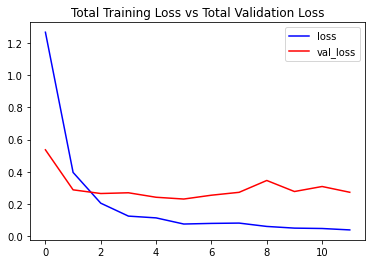

In [38]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

## **Plotting Training accuracy vs Validation accuracy**

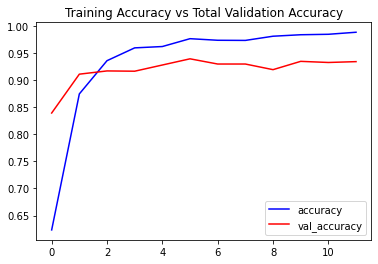

In [57]:
plot_metric('accuracy', 'val_accuracy', 'Training Accuracy vs Total Validation Accuracy')

# **Designing the Model 2**

In [40]:
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

## **Defining the input architecture for Model**

## **Encoder**

In [41]:
no_of_channels = 3
timesteps = 1
video_input = Input(shape=(timesteps,
                           image_height,
                            image_width,
                            no_of_channels))

In [42]:
VGG16_base = VGG16(input_shape=(image_height,
                              image_width,
                              no_of_channels),
                 weights="imagenet",
                 include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [43]:
VGG16_output = GlobalAveragePooling2D()(VGG16_base.output)

In [44]:
VGG16_model = Model(inputs = VGG16_base.input, outputs = VGG16_output)

In [45]:
VGG16_model.trainable = False

In [46]:
VGG16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## **Decoder**

In [47]:
video_frames_encoded = TimeDistributed(VGG16_model)(video_input)

In [48]:
no_of_classes = 12

In [49]:
video_frames_encoded_sequence = LSTM(256)(video_frames_encoded)
video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)

hidden_layer1 = Dense(1024, activation="relu")(video_frames_encoded_sequence)
hidden_layer1 = Dropout(0.5)(hidden_layer1)

hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
hidden_layer2 = Dropout(0.5)(hidden_layer2)

hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
hidden_layer3 = Dropout(0.25)(hidden_layer3)

hidden_layer4 =  Dense(128, activation="relu")(hidden_layer3)
hidden_layer4 = Dropout(0.25)(hidden_layer4)

hidden_layer5 =  Dense(64, activation="relu")(hidden_layer4)
hidden_layer5 = Dropout(0.25)(hidden_layer5)

outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)
model = Model([video_input], outputs)

In [50]:
optimizer = Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

In [51]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 64, 64, 3)]    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 512)            14714688  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5248

In [53]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(patience=7)
callbacks = [early_stopping_callback]

In [54]:
features_train.shape

(19200, 1, 64, 64, 3)

In [55]:
features_train = features_train.reshape(19200, 1, 64, 64, 3)

In [56]:
labels_train.shape

(19200, 12)

In [ ]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 30, 
                                   batch_size = 16,
                                   shuffle = True, 
                                   validation_split = 0.2)

Epoch 1/30
960/960 [==============================] - 72s 18ms/step - loss: 2.0940 - accuracy: 0.2437 - val_loss: 1.0764 - val_accuracy: 0.6039
Epoch 2/30
960/960 [==============================] - 15s 16ms/step - loss: 1.2142 - accuracy: 0.6060 - val_loss: 0.7096 - val_accuracy: 0.7737
Epoch 3/30
960/960 [==============================] - 16s 16ms/step - loss: 0.9134 - accuracy: 0.7002 - val_loss: 0.6286 - val_accuracy: 0.8055
Epoch 4/30
960/960 [==============================] - 16s 16ms/step - loss: 0.8673 - accuracy: 0.7330 - val_loss: 0.5152 - val_accuracy: 0.8513
Epoch 5/30
960/960 [==============================] - 16s 16ms/step - loss: 0.7229 - accuracy: 0.7877 - val_loss: 0.3742 - val_accuracy: 0.8956
Epoch 6/30
960/960 [==============================] - 15s 16ms/step - loss: 0.6509 - accuracy: 0.8108 - val_loss: 0.3653 - val_accuracy: 0.9094
Epoch 7/30
960/960 [==============================] - 16s 16ms/step - loss: 0.6135 - accuracy: 0.8336 - val_loss: 0.3160 - val_accuracy:

In [ ]:
features_test.shape

(4800, 64, 64, 3)

In [ ]:
features_test = features_test.reshape(4800,1, 64, 64, 3)

In [ ]:
import datetime as dt

model2_evaluation_history = model.evaluate(features_test, labels_test)

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()

current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# Saving your Model
model.save(model_name)


150/150 [==============================] - 5s 15ms/step - loss: 0.1548 - accuracy: 0.9631


In [ ]:
labels_pred = model.predict(features_test)

In [ ]:
labels_pred = np.argmax(labels_pred, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()


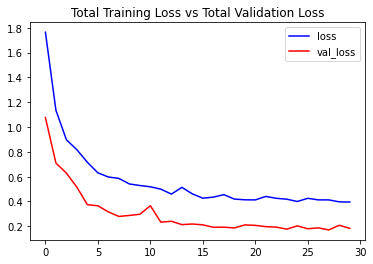

In [ ]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

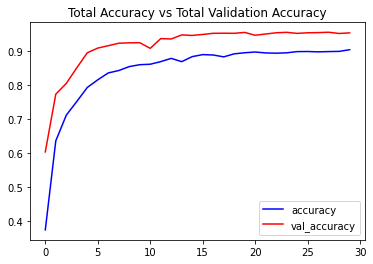

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')